In [2]:
import pandas as pd
import seaborn as sns
from nlpaug.augmenter.word import ContextualWordEmbsAug
from sklearn.utils import shuffle
from tqdm import tqdm
import numpy as np

In [3]:
train_dataset_df = pd.read_csv('./dataset/OSACT2022-sharedTask-train.csv', usecols=['tweet', 'off_label', 'hs_label'])
print(train_dataset_df.describe())
train_dataset_df.head()

                      tweet off_label hs_label
count                  8887      8887     8887
unique                 8887         2        6
top      ردينا ع التطنز 😏👊🏻   NOT_OFF   NOT_HS
freq                      1      5715     7928


,tweet,off_label,hs_label
0,ردينا ع التطنز 😏👊🏻,OFF,NOT_HS
1,وصارت فطاير البقالات غذاء صحي 👎🏻,NOT_OFF,NOT_HS
2,روحي لبريده تلقين اشباه كثير بس ماحد زيكم مشف...,OFF,NOT_HS
3,مش باين حاجه خالص 😣مش عارف بقى 😔,NOT_OFF,NOT_HS
4,#اليوم_الاثنين👏 يقولك :%90 من المسلمين عندهم ...,NOT_OFF,NOT_HS


NOT_OFF    5715
OFF        3172
Name: off_label, dtype: int64


<AxesSubplot:xlabel='off_label', ylabel='count'>

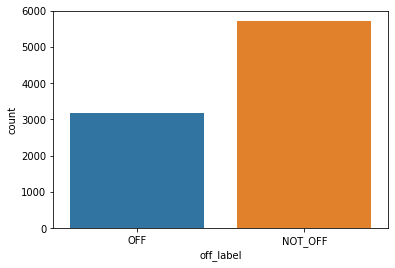

In [24]:
print(train_dataset_df['off_label'].value_counts())
sns.countplot(data = train_dataset_df , x='off_label')

NOT_HS    7928
HS         959
Name: hs_label, dtype: int64


<AxesSubplot:xlabel='hs_label', ylabel='count'>

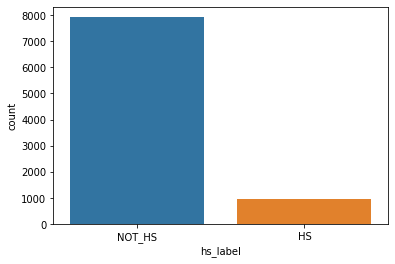

In [4]:

train_dataset_df.loc[train_dataset_df['hs_label'] == 'HS1', 'hs_label'] = 'HS'
train_dataset_df.loc[train_dataset_df['hs_label'] == 'HS2', 'hs_label'] = 'HS'
train_dataset_df.loc[train_dataset_df['hs_label'] == 'HS3', 'hs_label'] = 'HS'
train_dataset_df.loc[train_dataset_df['hs_label'] == 'HS4', 'hs_label'] = 'HS'
train_dataset_df.loc[train_dataset_df['hs_label'] == 'HS5', 'hs_label'] = 'HS'
train_dataset_df.loc[train_dataset_df['hs_label'] == 'HS6', 'hs_label'] = 'HS'
train_dataset_df.loc[(train_dataset_df['hs_label'] == 'NOT_HS'), 'hs_label'] = 'NOT_HS'
print(train_dataset_df['hs_label'].value_counts())
sns.countplot(data = train_dataset_df , x='hs_label')

In [5]:
# BERT Augmentator
TOPK=20 #default=100
ACT = 'insert' #"substitute"

aug_bert = ContextualWordEmbsAug(
    model_path= 'UBC-NLP/MARBERT',
#     model_path='distilbert-base-uncased', 
    # device='cuda',
    action=ACT, top_k=TOPK)

def augment_text(df, augmenter, label_name, label_val, samples=100, pr=0.2, show = 0):
    augmenter.aug_p = pr
    new_text=[]
    
    # selecting the minority class samples
    df_n = df[df[label_name]==label_val].reset_index(drop=True)

    # data augmentation loop
    for i in tqdm(np.random.randint(0, len(df_n), samples)):
            text = df_n.iloc[i]['tweet']
            augmented_text = augmenter.augment(text)
            if show:
                print(f"The original text: {text}")
                print(f"The augmented text: {augmented_text}")
                print('-'*100)
            new_text.append(augmented_text)
    
    # dataframe
    new = pd.DataFrame({'tweet':new_text,label_name:label_val})
    df = shuffle(pd.concat([df,new]).reset_index(drop=True))
    return df

In [27]:
#show sample of augmented offensive tweets
aug_df = augment_text(train_dataset_df, aug_bert, 'off_label', label_val ='OFF', samples=5, show=True)

 20%|██        | 1/5 [00:00<00:00,  7.86it/s]

The original text: الريس يخصص ٢٧٥ مليار جنيه ل تنميه شامله ل سيناء ....علشان اسرائيل تأخذ سيناء سوبر لوكس علي مفتاااح 🐑🐏
The augmented text: يعني الريس لازم يخصص ٢٧٥ مليار جنيه ل مشروع تنميه شامله شامله ل شبه سيناء.... علشان اسراييل تاخذ مشروع سيناء سوبر لوكس علي مفتاااح [UNK]
----------------------------------------------------------------------------------------------------
The original text: بنات الشعبه عندهم وسواس قهري في المواد يسألون عن تفاصيل التفاصيل 😷😷😷خصوصا وحده تحب توسوس نفسي اصفقها
The augmented text: بنات الشعبه عندهم وسواس و قهري في المواد ولازم يسالون عن تفاصيل التفاصيل 😷😷😷خصوصا مع وحده تحب ولا توسوس 😂😂 نفسي اصفقها
----------------------------------------------------------------------------------------------------


100%|██████████| 5/5 [00:00<00:00,  9.95it/s]

The original text:  نعم فعلاً اقولها من تجربة ومن خلال رؤيتي بأن المعلمين بحاجة مستمرة لدورات تثقيفية يعني مو معقولة كل المعلمات اللي بالمدرسة تحسهم مش متعلمات من طريقة كلامهم وتعاملهم مع الطالبات شيء فظيع والله😣
The augmented text: اي نعم فعلا اقولها من تجربة ومن خلال رويتي بان المعلمين بحاجة وبشكل مستمرة لدورات تثقيفية يعني مو معقولة لو كل المعلمات زي اللي عندنا بالمدرسة تحسهم حتى مش متعلمات من طريقة كلامهم وتعاملهم السلبي مع الطالبات شيء جد فظيع والله😣
----------------------------------------------------------------------------------------------------
The original text: ابغى الي قصة شعره وسوت فيه كذا وينها الكلبه وينها حسبي عليك مع هالصباح😣💔 
The augmented text: بموت ابغى الي عجبه قصة شعره وسوت تسوي فيه كذا وينها الكلبه وينها الكلبه حسبي عليك مع هالصباح😣💔
----------------------------------------------------------------------------------------------------
The original text: اما بشوف واحده مطلعه شعرايه واحده بره الطرحه ببقه عايز اتف في وشها😡😡لاما تبقي قده لاما تقلعيه خالص😡😡
The augmen

In [28]:
#show sample of augmented hate speech tweets
aug_df = augment_text(train_dataset_df, aug_bert, 'hs_label', label_val ='HS', samples=5, show=True)

 60%|██████    | 3/5 [00:00<00:00, 11.97it/s]

The original text:  ودي يمسكونك انت وامثاله ويخلونككم عبره لكل معتبر فاقد للرجوله 😎ماتقوم رجولتكم الا ع انثى بس 👎🏻
The augmented text: ودي بعد يمسكونك انت وامثاله ويخلونككم عبره لكل شخص معتبر ، فاقد الضمير للرجوله 😎ماتقوم رجولتكم الا بالضرب ع انثى بس 👎🏻
----------------------------------------------------------------------------------------------------
The original text:   في أوروبا تمر عليك البنت مع قليل من المكياج. أما عندنا يمر عليك المكياج مع قليل من البنت 🌚🔪😂😂
The augmented text: في اوروبا تمر عليك مكياج البنت مع قليل من المكياج. اما حنا عندنا عادي يمر عليك المكياج كامل مع شوية قليل من البنت 🌚🔪😂😂
----------------------------------------------------------------------------------------------------
The original text:  بتعملوا ف ديك أبونا كده ليه هو إحنا كفرة ولايهود... وربنا إحنا ماشيين بالعلاج 😡😡😡😡
The augmented text: بتعملوا ايه ف ابن ديك ابونا ياجماعة كده ليه هو احنا كفرة ولايهود... وربنا احنا ماشيين بالعلاج اهو 😡😡😡😡
----------------------------------------------------------------

100%|██████████| 5/5 [00:00<00:00,  9.46it/s]

The original text:  حلوووب جدا جدا جدا لعيون ايفاانكا ٤٨٠ مليار دولار عقبها خلوووك تدفع ضرائب ياا 🐑🐑
The augmented text: قوول حلوووب جدا جدا جدا لعيون ايفاانكا ٤٨٠ مليار دولار عقبها قولوا خلوووك تدفع اول ضرايب علينا ياا حمار 🐑🐑
----------------------------------------------------------------------------------------------------
The original text: اقسم ب الله ناس أصبحت مقرفة برمي الأسامي و التهم ع كل من كان له فكر حر .. يشتو مطبلين و قطيع .. انقلعو الله يقرفكم فاض الكيل بنا منكم !!! 😠😷
The augmented text: اقسم ب غضب الله ناس اصبحت مقرفة حتى برمي الاسامي و التهم ع كل من هو كان له فكر او حر.. يشتو مطبلين حمير و قطيع.. انقلعو الله لا يقرفكم فاض الكيل بنا الكيل منكم!!! 😒 😠😷
----------------------------------------------------------------------------------------------------


In [6]:
#augment offensive tweets
off_count = train_dataset_df.loc[train_dataset_df['off_label'] == 'OFF'].shape[0]
not_off_count = train_dataset_df.loc[train_dataset_df['off_label'] == 'NOT_OFF'].shape[0]
num_samples = not_off_count - off_count
off_aug_df = augment_text(train_dataset_df, aug_bert,label_name='off_label', label_val ='OFF', samples=num_samples, show=False)
off_aug_df["tweet"] = [string.replace("[UNK]", "")  for string in off_aug_df['tweet']]
off_aug_df['tweet'] = off_aug_df['tweet'].astype(str)

100%|██████████| 2543/2543 [17:44<00:00,  2.39it/s]


In [94]:
#augment hate speech tweets
hs_count = train_dataset_df.loc[train_dataset_df['hs_label'] == 'HS'].shape[0]
not_hs_count = train_dataset_df.loc[train_dataset_df['hs_label'] == 'NOT_HS'].shape[0]
num_samples = not_hs_count - hs_count
hs_aug_df = augment_text(train_dataset_df, aug_bert, label_name='hs_label', label_val='HS', samples=num_samples, show=False)
hs_aug_df['tweet'] = [string.replace("[UNK]", "") for string in hs_aug_df['tweet']]
hs_aug_df['tweet'] = hs_aug_df['tweet'].astype(str)

100%|██████████| 6969/6969 [1:07:21<00:00,  1.72it/s]


In [7]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
marbert_model_path = 'UBC-NLP/MARBERT'
tokenizer = AutoTokenizer.from_pretrained(marbert_model_path, from_tf=True)
marbert_model = TFAutoModel.from_pretrained(marbert_model_path, output_hidden_states=True)

def bert_tokenize(texts: str) -> list:
    max_len = 0
    for text in texts:
        max_len = max(len(tokenizer.tokenize(f'[CLS] {text} [SEP]')), max_len)
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=max_len)
    return (tokens['input_ids'], tokens['attention_mask'], tokens['token_type_ids'])

def get_embeddings(tokens):
    ids = tf.convert_to_tensor(tokens[0])
    mask = tf.convert_to_tensor(tokens[1])
    type_ids = tf.convert_to_tensor(tokens[2])
    hidden_states = marbert_model(input_ids=ids, attention_mask=mask, token_type_ids=type_ids)[2]
    sentence_embd = tf.reduce_mean(tf.reduce_sum(tf.stack(hidden_states[-4:]), axis = 0), axis=1)
    return sentence_embd

2022-04-13 15:01:54.391504: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-13 15:01:54.391631: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kirollos-G3-3500
2022-04-13 15:01:54.391666: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kirollos-G3-3500
2022-04-13 15:01:54.404566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-04-13 15:01:54.404710: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-04-13 15:01:54.404747: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-04-13 15:01:54.406387: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU 

In [8]:
#prepare offensive task labels
off_aug_df.loc[off_aug_df['off_label'] == 'OFF', 'off_label'] = 1
off_aug_df.loc[off_aug_df['off_label'] == 'NOT_OFF', 'off_label'] = 0
del off_aug_df['hs_label']
off_aug_df['off_label'] = off_aug_df['off_label'].astype(np.int32)
y_train_offensive = off_aug_df['off_label'].values
print(y_train_offensive.shape)
print(y_train_offensive.dtype)

(11430,)
int32


In [ ]:
# extract training features for hate speech task
text_offensive = off_aug_df['tweet'].values 
batch_size = 64
train_num_batches = text_offensive.shape[0] // batch_size
train_rem = text_offensive.shape[0] % batch_size

x_train_offensive = np.empty(shape=(text_offensive.shape[0], 768), dtype=np.float64)
for batch_step in tqdm(range(1, train_num_batches), desc='getting training features..'):
    i = batch_step - 1
    tokens = bert_tokenize(list(text_offensive[i * batch_size: batch_step * batch_size]))
    x_train_offensive[i * batch_size : batch_step * batch_size] = get_embeddings(tokens)

if train_rem != 0:
    tokens = bert_tokenize(list(text_offensive[text_offensive.shape[0] - train_rem: ]))
    x_train_offensive[text_offensive.shape[0] - train_rem: ] = get_embeddings(tokens)

print(x_train_offensive.shape)

In [95]:
#prepare hate speech task labels
hs_aug_df.loc[hs_aug_df['hs_label'] == 'HS', 'hs_label'] = 1
hs_aug_df.loc[hs_aug_df['hs_label'] == 'NOT_HS', 'hs_label'] = 0
del hs_aug_df['off_label']
hs_aug_df['hs_label'] = hs_aug_df['hs_label'].astype(np.int32)
y_train_hs = hs_aug_df['hs_label'].values
print(y_train_hs.shape)
print(y_train_hs.dtype)

(15856,)
int32


In [96]:
# extract training features for hate speech task
text_hs = hs_aug_df['tweet'].values 
batch_size = 64
train_num_batches = text_hs.shape[0] // batch_size
train_rem = text_hs.shape[0] % batch_size

x_train_hs = np.empty(shape=(text_hs.shape[0], 768), dtype=np.float64)
for batch_step in tqdm(range(1, train_num_batches), desc='getting training features..'):
    i = batch_step - 1
    tokens = bert_tokenize(list(text_hs[i * batch_size: batch_step * batch_size]))
    x_train_hs[i * batch_size : batch_step * batch_size] = get_embeddings(tokens)

if train_rem != 0:
    tokens = bert_tokenize(list(text_hs[text_hs.shape[0] - train_rem: ]))
    x_train_hs[text_hs.shape[0] - train_rem: ] = get_embeddings(tokens)

print(x_train_hs.shape)

getting training features..: 100%|██████████| 246/246 [30:39<00:00,  7.48s/it]


(15856, 768)


In [97]:
#read development dataset and prepare offensive and hate speech labels
dev_dataset_df = pd.read_csv('./dataset/OSACT2022-sharedTask-dev.csv', usecols=['tweet','off_label', 'hs_label'])
dev_dataset_df.loc[dev_dataset_df['off_label'] == 'OFF', 'off_label'] = 1
dev_dataset_df.loc[dev_dataset_df['off_label'] == 'NOT_OFF', 'off_label'] = 0
dev_dataset_df['off_label'] = dev_dataset_df['off_label'].astype(np.int32)
y_dev_offensive = dev_dataset_df['off_label'].values

dev_dataset_df.loc[dev_dataset_df['hs_label'] == 'HS1', 'hs_label'] = 1
dev_dataset_df.loc[dev_dataset_df['hs_label'] == 'HS2', 'hs_label'] = 1
dev_dataset_df.loc[dev_dataset_df['hs_label'] == 'HS3', 'hs_label'] = 1
dev_dataset_df.loc[dev_dataset_df['hs_label'] == 'HS4', 'hs_label'] = 1
dev_dataset_df.loc[dev_dataset_df['hs_label'] == 'HS5', 'hs_label'] = 1
dev_dataset_df.loc[dev_dataset_df['hs_label'] == 'HS6', 'hs_label'] = 1
dev_dataset_df.loc[(dev_dataset_df['hs_label'] == 'NOT_HS'), 'hs_label'] = 0
dev_dataset_df['hs_label'] = dev_dataset_df['hs_label'].astype(np.int32)
y_dev_hs = dev_dataset_df['hs_label'].values

In [98]:
#extract development dataset features
text_offensive = dev_dataset_df['tweet'].values 
batch_size = 64
dev_num_batches = text_offensive.shape[0] // batch_size
dev_rem = text_offensive.shape[0] % batch_size

x_dev = np.empty(shape=(text_offensive.shape[0], 768), dtype=np.float64)
for batch_step in tqdm(range(1, dev_num_batches), desc='getting dev features..'):
    i = batch_step - 1
    tokens = bert_tokenize(list(text_offensive[i * batch_size: batch_step * batch_size]))
    x_dev[i * batch_size : batch_step * batch_size] = get_embeddings(tokens)

if dev_rem != 0:
    tokens = bert_tokenize(list(text_offensive[text_offensive.shape[0] - dev_rem: ]))
    x_dev[text_offensive.shape[0] - dev_rem: ] = get_embeddings(tokens)

print(x_dev.shape)

getting dev features..: 100%|██████████| 18/18 [01:47<00:00,  5.98s/it]


(1270, 768)


In [67]:
#logistic regression model for offensive task
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

scaler = StandardScaler()
x_train_offensive = scaler.fit_transform(x_train_offensive, y_train_offensive)

x_train, x_test, y_train, y_test = train_test_split(x_train_offensive, y_train_offensive, test_size=0.3)

offensive_lr_model = LogisticRegression(verbose=2, solver='saga', C=1e-3)

offensive_lr_model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20669558
Epoch 3, change: 0.10823747
Epoch 4, change: 0.06977143
Epoch 5, change: 0.04783693
Epoch 6, change: 0.02658286
Epoch 7, change: 0.01648776
Epoch 8, change: 0.01105328
Epoch 9, change: 0.00894443
Epoch 10, change: 0.00493904
Epoch 11, change: 0.00387966
Epoch 12, change: 0.00325783
Epoch 13, change: 0.00242496
Epoch 14, change: 0.00170599
Epoch 15, change: 0.00131166
Epoch 16, change: 0.00113192
Epoch 17, change: 0.00081929
Epoch 18, change: 0.00065565
Epoch 19, change: 0.00047070
Epoch 20, change: 0.00039170
Epoch 21, change: 0.00027360
Epoch 22, change: 0.00021646
Epoch 23, change: 0.00017753
Epoch 24, change: 0.00012184
Epoch 25, change: 0.00010307
convergence after 26 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


LogisticRegression(C=0.001, solver='saga', verbose=2)

In [ ]:
#evaluate logistic regression on training, test and development datasets for offensive task
x_dev_offensive = scaler.fit(x_dev)
print('train data confusion matrix:')
train_data_conf_matrix = classification_report(y_train, offensive_lr_model.predict(x_train), target_names=['not_off', 'off'])
print(train_data_conf_matrix)
print('test data confusion matrix:')
test_data_conf_matrix = classification_report(y_test, offensive_lr_model.predict(x_test), target_names=['not_off', 'off'])
print(test_data_conf_matrix)
print('dev data confusion matrix:')
dev_data_conf_matrix = classification_report(y_dev_offensive, offensive_lr_model.predict(x_dev_offensive), target_names=['not_off', 'off'])
print(dev_data_conf_matrix)

In [70]:
#random forest model for offensive task
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

scaler = StandardScaler()
x_train_offensive = scaler.fit_transform(x_train_offensive, y_train_offensive)

x_train, x_test, y_train, y_test = train_test_split(x_train_offensive, y_train_offensive, test_size=0.3)

offensive_rf_model = RandomForestClassifier(verbose=2, max_samples=0.4)

offensive_rf_model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.0s finished


RandomForestClassifier(max_samples=0.4, verbose=2)

In [ ]:
#evaluate random forest on training, test and development datasets for offensive task
x_dev_offensive = scaler.fit(x_dev)
print('train data confusion matrix:')
train_data_conf_matrix = classification_report(y_train, offensive_rf_model.predict(x_train), target_names=['not_off', 'off'])
print(train_data_conf_matrix)
print('test data confusion matrix:')
test_data_conf_matrix = classification_report(y_test, offensive_rf_model.predict(x_test), target_names=['not_off', 'off'])
print(test_data_conf_matrix)
print('dev data confusion matrix:')
dev_data_conf_matrix = classification_report(y_dev_offensive, offensive_rf_model.predict(x_dev_offensive), target_names=['not_off', 'off'])
print(dev_data_conf_matrix)

In [99]:
#logistic regression model for hate speech task
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

scaler = StandardScaler()
x_train_hs = scaler.fit_transform(x_train_hs, y_train_hs)

x_train, x_test, y_train, y_test = train_test_split(x_train_hs, y_train_hs, test_size=0.3)

hs_lr_model = LogisticRegression(verbose=2, solver='saga', C=1e-3)

hs_lr_model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22245601
Epoch 3, change: 0.13065225
Epoch 4, change: 0.06529777
Epoch 5, change: 0.04371365
Epoch 6, change: 0.03118205
Epoch 7, change: 0.01940550
Epoch 8, change: 0.01335161
Epoch 9, change: 0.01064205
Epoch 10, change: 0.00771064
Epoch 11, change: 0.00414935
Epoch 12, change: 0.00285662
Epoch 13, change: 0.00210780
Epoch 14, change: 0.00152659
Epoch 15, change: 0.00118896
Epoch 16, change: 0.00093127
Epoch 17, change: 0.00068015
Epoch 18, change: 0.00054178
Epoch 19, change: 0.00038536
Epoch 20, change: 0.00028793
Epoch 21, change: 0.00021724
Epoch 22, change: 0.00016804
Epoch 23, change: 0.00012574
convergence after 24 epochs took 2 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


LogisticRegression(C=0.001, solver='saga', verbose=2)

In [ ]:
#evaluate logistic regression on training, test and development datasets for hate speech task
x_dev_hs = scaler.fit(x_dev)
print('train data confusion matrix:')
train_data_conf_matrix = classification_report(y_train, hs_lr_model.predict(x_train), target_names=['not_hs', 'hs'])
print(train_data_conf_matrix)
print('test data confusion matrix:')
test_data_conf_matrix = classification_report(y_test, hs_lr_model.predict(x_test), target_names=['not_hs', 'hs'])
print(test_data_conf_matrix)
print('dev data confusion matrix:')
dev_data_conf_matrix = classification_report(y_dev_offensive, hs_lr_model.predict(x_dev_hs), target_names=['not_hs', 'hs'])
print(dev_data_conf_matrix)

In [101]:
#random forest model for hate speech task
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

scaler = StandardScaler()
x_train_hs = scaler.fit_transform(x_train_hs, y_train_hs)

x_train, x_test, y_train, y_test = train_test_split(x_train_hs, y_train_hs, test_size=0.3)

hs_rf_model = RandomForestClassifier(verbose=2, max_samples=0.4)

hs_rf_model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.1s finished


RandomForestClassifier(max_samples=0.4, verbose=2)

In [ ]:
#evaluate random forest on training, test and development datasets for hate speech task
x_dev_hs = scaler.fit(x_dev)
print('train data confusion matrix:')
train_data_conf_matrix = classification_report(y_train, hs_rf_model.predict(x_train), target_names=['not_hs', 'hs'])
print(train_data_conf_matrix)
print('test data confusion matrix:')
test_data_conf_matrix = classification_report(y_test, hs_rf_model.predict(x_test), target_names=['not_hs', 'hs'])
print(test_data_conf_matrix)
print('dev data confusion matrix:')
dev_data_conf_matrix = classification_report(y_dev_offensive, hs_rf_model.predict(x_dev_hs), target_names=['not_hs', 'hs'])
print(dev_data_conf_matrix)